# rf-SQUID

Radio frequency superconducting quantum interference devices (rf SQUIDs) made of conventional superconductors had been very popular some fifteen to thirty years ago. Later on, they had been replaced by dc SQUIDs, which then offered higher sensitivity. However, the operation of rf SQUIDs at microwave bias frequencies has greatly improved their sensitivity, so that now rf SQUIDs can be fabricated which are comparable to the best dc SQUIDs in terms of field sensitivity, as well as energy resolution. The discovery of high temperature superconductors (HTS) has further increased interest in rf SQUIDs, mainly because the inductance of rf SQUIDs and thus their loop area, can be made much larger than that of dc SQUIDs before a significant reduction in signal voltage is observed. Today, rf SQUIDs are again used in numerous applications, such as biomagnetism, geophysical measurements and nondestructive evaluation.

The interesting aspect of this device is that it as a tunable non-linearity. Differently from the dc SQUID, whose non-linearity is strictly negative, the rf SQUID non-linearity could be tuned to take positive and negative values.

The Hamiltonian of the rf-SQUID reads:
$$ \hat{H}_{rf} = E_C \hat{N}^2 + E_L[\hat{\varphi} - \varphi_x]^2 - E_J cos(\hat{\varphi}) $$

In [3]:
import scqubits as scq
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Circuit construction

In [4]:
# Generate the rf-SQUID circuit yaml file
rf_squid_yaml = """
# rf-SQUID circuit
branches:
 - ["JJ", 1, 2, EJ=100, ECJ =20]
 - ["L" , 1, 2, EL=500]
 - ["C" , 1, 2, EC=0.5]
 """

In [5]:
# Create the rf-SQUID circuit object
rf_squid = scq.Circuit(rf_squid_yaml, from_file= False, ext_basis='harmonic' )

In [6]:
rf_squid.sym_hamiltonian()

<IPython.core.display.Latex object>

In [7]:
rf_squid.sym_external_fluxes()

{Φ1: (Branch(L, 1, 2, id_str: 1),
  [Branch(JJ, 1, 2, id_str: 0), Branch(L, 1, 2, id_str: 1)])}

## Spectrum

In [8]:
phi_list = np.linspace(-2, 2, 500)
rf_squid.plot_evals_vs_paramvals("Φ1", phi_list)
rf_squid.plot_evals_vs_paramvals("Φ1", phi_list, subtract_ground=True)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

## Potential

In [8]:
rf_squid.potential_symbolic

-EJ*cos(1.0*θ1) + 0.5*EL*Φ1**2 + 0.5*EL*θ1**2 - 1.0*EL*Φ1*θ1

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='$\\theta_{1}$', ylabel='Potential energy in GHz'>)

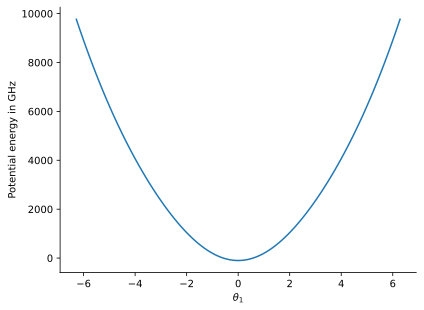

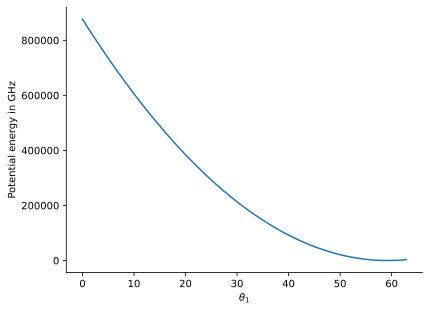

In [9]:
rf_squid.Φ1 = 0
rf_squid.plot_potential(θ1=np.linspace(-2 * np.pi, 2 * np.pi, 100))
rf_squid.Φ1 = 1.5
rf_squid.plot_potential(θ1=np.linspace(0, 20 * np.pi, 100))

## Anharmonicity

In [10]:
def plot_anharmonicity(qubit, fluxes):
    anharm = np.array([])
    for f in fluxes:
        qubit.Φ1 = f
        anharm = np.append(anharm, qubit.anharmonicity())
    plt.plot(fluxes, anharm)
    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("$\Phi_1$")
    plt.ylabel("Anharmonicity [GHz]")

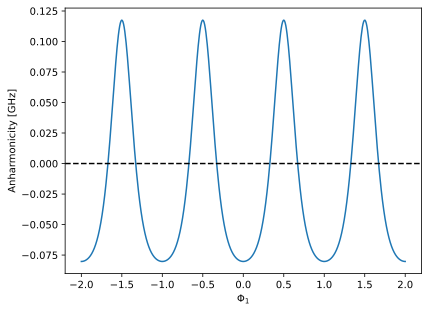

In [11]:
plot_anharmonicity(rf_squid, phi_list)

In [12]:
an = np.array([])
an_2 = np.array([])

for f in phi_list:
    rf_squid.Φ1 = f
    eigenvals = rf_squid.eigenvals(evals_count=4)
    an = np.append(an, eigenvals[2] - 2 * eigenvals[1] + eigenvals[0])
    an_2 = np.append(an_2, eigenvals[3] - 2 * eigenvals[2] + eigenvals[1])

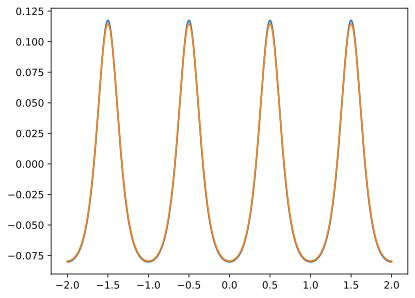

In [13]:
plt.plot(phi_list, an)
plt.plot(phi_list, an_2)

# Analytic hamiltonian

In [14]:
# Parameters
N = 30
EJ_an = 100
EL_an = 500
EC_an = 0.5
flux = 0
zeta = np.sqrt(4 * EC_an / (EL_an + EJ_an / 2))
hbar = sp.constants.hbar
e = sp.constants.e
phi0 = hbar / (2 * e)

In [16]:
# Hamiltonian
def rfsquid_analytic_ham(flux):
    hamiltonian = np.array(
        [
            (
                4 * EC_an / zeta
                + EL_an * zeta
                + EJ_an * zeta * np.cos(flux) / 2
                - EJ_an * zeta**2 * np.cos(flux) / 8
                + EJ_an * zeta**2 * np.cos(flux) / 16
            )
            * n
            - EJ_an * zeta**2 * np.cos(flux) / 16 * n**2
            for n in range(1, N + 1)
        ]
    )
    return np.diag(hamiltonian)

In [17]:
phi_list = np.linspace(-2, 2, 500)

E0_an = np.array([])
E1_an = np.array([])
E2_an = np.array([])

for flux in phi_list:
    E0_an = np.append(E0_an, rfsquid_analytic_ham(flux)[0][0])
    E1_an = np.append(E1_an, rfsquid_analytic_ham(flux)[1][1])
    E2_an = np.append(E2_an, rfsquid_analytic_ham(flux)[2][2])

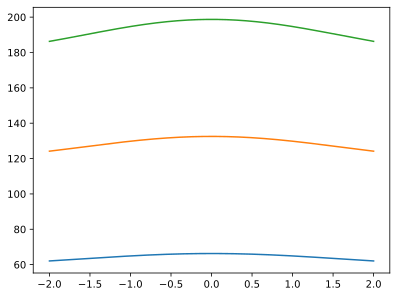

In [18]:
#Analytic eigenenergies
plt.plot(phi_list, E0_an)
plt.plot(phi_list, E1_an)
plt.plot(phi_list, E2_an)

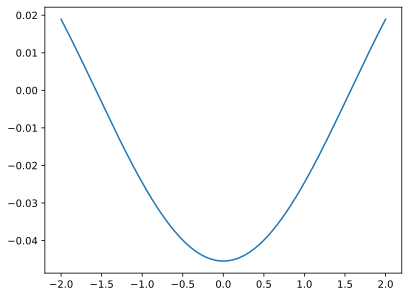

In [19]:
#Analytic anharmonicity
plt.plot(phi_list, E2_an - 2 * E1_an + E0_an)